In [134]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, IBMQ
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap
from qiskit.visualization import plot_histogram, plot_distribution

from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.primitives import Sampler, Estimator

import numpy as np
import matplotlib.pyplot as plt

In [237]:
# Method to construct the Convolutional Layer for the QCNN
def conv_layer(qc:QuantumCircuit(), para:ParameterVector, iter:int) -> QuantumCircuit():
    start = 0 if qc.num_qubits == 2 else -1
    iter = 3 if iter == 0 else iter
    for i in range(start, qc.num_qubits-1):
        qc.rz(-np.pi / 2, i+1)
        qc.cx(i+1, i)
        qc.rz(para[(3*i)+iter], i)
        qc.ry(para[(3*i)+1+iter], i+1)
        qc.cx(i, i+1)
        qc.ry(para[(3*i)+2+iter], i+1)
        qc.cx(i+1, i)
        qc.rz(np.pi / 2, i)
        qc.barrier()
    if iter == 3:
        iter = 0
    if qc.num_qubits == 2:
        iter += 3
    else: 
        iter += (3*(qc.num_qubits)) 
    return qc, iter

# Method to construct the Pooling Layer for the QCNN
def pool_layer(qc:QuantumCircuit(), para:ParameterVector, iter:int) -> QuantumCircuit():
    half = int(qc.num_qubits/2)
    for i in range(half):
        qc.rz(-np.pi / 2, i+half)
        qc.cx(i+half, i)
        qc.rz(para[(3*i)+iter], i)
        qc.ry(para[(3*i)+1+iter], i+half)
        qc.cx(i, i+half)
        qc.ry(para[(3*i)+2+iter], i+half)
        qc.barrier()
    iter += (half*3)
    return qc, iter

# Method that builds the entire circuit and layers systematically
def qcnn_circuit(num_qubits:int) -> QuantumCircuit():
    qc = QuantumCircuit(num_qubits)
    num_layers = np.log2(num_qubits) # Calculates number of convolutional/pooling layers
    
    feature_map = ZFeatureMap(num_qubits)  # Pulls in Qiskit's built in ZFeatureMap
    qc.compose(feature_map, range(num_qubits), inplace=True) # Adds ZFeatureMap to circuit for initialization
    
    parameter_vec = ParameterVector(name="θ", length=int(9*(2**num_layers))-12) # Calculates number of parameters needed
   
    iter = 0 # Tracks where in the Parameter Vector to put the next parameter
    index = num_qubits # Divides itself in half at each layer
    layer = 1 # Tracks the current layer being constructed
    while index > 1: # Adds 1 convolution layer and 1 pooling layer then iterates
        conv_qc = QuantumCircuit(index)
        pool_qc = QuantumCircuit(index)
        # Adds 1 convolutional layer to the circuit by converting the convolutional circuit to a gate
        conv_qc, iter = conv_layer(conv_qc, parameter_vec, iter)
        qc.compose(conv_qc.to_instruction(label=f'Convolution Layer {layer}'), range(int(num_qubits - index), num_qubits), inplace=True)
        
        # Adds 1 pooling layer to the circuit by converting the pooling circuit to a gate
        pool_qc, iter = pool_layer(pool_qc, parameter_vec, iter)
        qc.compose(pool_qc.to_instruction(label=f'Pooling Layer {layer}'), range(int(num_qubits - index), num_qubits), inplace=True)

        # Handle tracker increment or decrement
        index = int(index / 2)
        layer += 1
    return qc


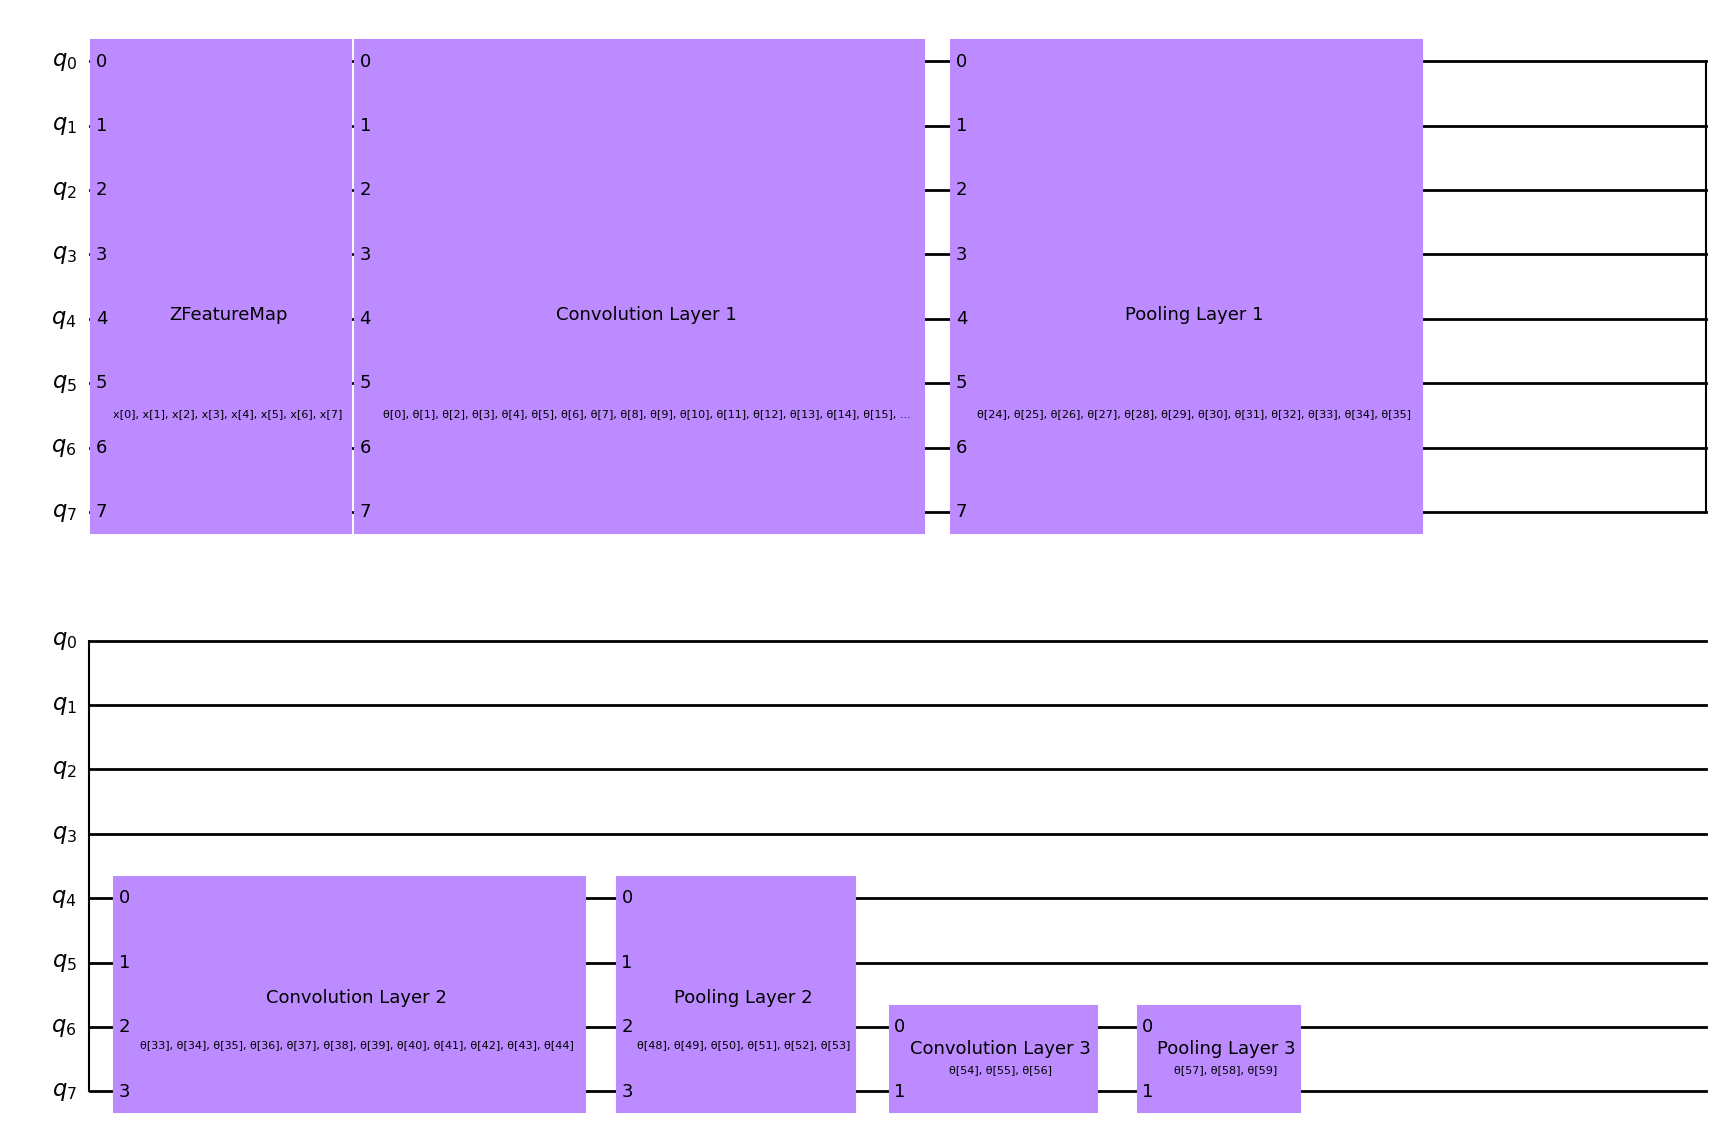

In [238]:
#2 qubits = 6 parameters
#4 qubits = 24 parameters
#8 qubtes = 60 parameters
qcnn = qcnn_circuit(8)

qcnn.draw("mpl", style="clifford")